In [4]:
import warnings
warnings.filterwarnings('ignore')

import collections
import glob 
import os
import warnings
from glob import glob
                                                                 
import joblib                                                    
import matplotlib.pyplot as plt                                  
import numpy as np                                               
from astropy import table, units, constants                                     
from astropy.io import fits
import laspec
from laspec import normalization as lanorm
import lightkurve as lk

import copy
import os
import datetime
import logging
import warnings

import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
from matplotlib import pyplot as plt
from copy import deepcopy
from tqdm import tqdm
import pandas as pd

from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.io import fits
from astropy.time import Time
import lightkurve as lk



In [5]:
plt.style.use('lijiaostyle')

In [6]:
import sys
sys.path.append('../pyfile/')
import extract

In [7]:
### https://python4astronomers.github.io/astropy-UVES/UVES.html#normalize-the-flux-to-the-local-continuum

In [8]:
obslog  ={'20210127' : [17, 18],
          '20210128' : [11, 12, 13, 14, 16, 17, 18],
          '20210207' : [15, 16, 17, 18, 19],
          '20210213' : [15, 16, 17, 18]
}

In [9]:
direname = '/media/backup/240cm/HRS_reduced/'
filenames = []


for _date in obslog.keys():
    _is = obslog[_date]
    for _i in _is:
       _fname = f'{direname}/{_date}/{_date}/{_date}{_i:03d}_1ds.fits'
       filenames.append(_fname)

In [10]:
_fname = filenames[16]
def multispec(fname):
    spec = {}
    head = fits.getheader(fname)
    multiwave = np.zeros((head['NAXIS2'], head['NAXIS1']))
    multiflux = np.zeros((head['NAXIS2'], head['NAXIS1']))
    multispc = extract.load_multispec(fname)
    orders = np.zeros([head['NAXIS2']])
    for _i, order in enumerate(multispc.orders):
        orders[_i] = order
        multiwave[_i] = multispc.order[order].wv
        multiflux[_i] = multispc.order[order].flux
    specs = collections.OrderedDict(head = head,
                                  waves = multiwave,
                                  fluxs = multiflux)
    return specs

specs = multispec(_fname)

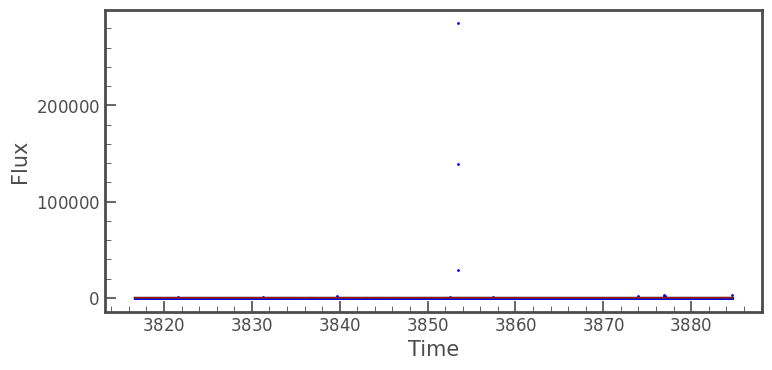

In [27]:
def rmcosimic(wave, flux, fluxerr, sigma =8, itera=2, percentile_up=100, percentile_low=0.01, window_length=7, 
              polyorder=2, 
              show=False):
    '''remove cosimic line of spec
    parameters:
    --------------
    wave [1d array]
    flux [1d array]
    fluxerr [1d array]
    sigma [float] exclude the flux which sigma*std
    itera [int] iteration number to calculate std
    percentile_up, percentile_low [float] calculate std by using the points that flux-trend_flux in the interval of [percentile_low, percentile_up]
    window_length [odd]
    '''
    spec = lk.LightCurve(time=wave,  flux=flux, flux_err=fluxerr)
    lc = spec.copy()
    ind_good = np.ones(len(lc.flux), dtype=np.bool)
    lc_detrend, lc_trend = lc.flatten(window_length=window_length, polyorder=polyorder, return_trend=True,
                break_tolerance=5, niters=3, sigma=3, mask=None)
    lcflux = spec.flux[ind_good] 
    lctrendflux = lc_trend.flux[ind_good]
    for i in np.arange(itera):
        diff_flux = lcflux  - lctrendflux
        std = np.std(diff_flux[(diff_flux < np.percentile(diff_flux, percentile_up)) & (diff_flux > np.percentile(diff_flux, percentile_low))])
        ind_good = diff_flux < sigma*std
        lcflux = lcflux[ind_good]
        lctrendflux= lctrendflux[ind_good]
        
    ind_bad = np.abs(lc.flux - lc_trend.flux) > sigma*std
    #print(std)
    lc.flux[ind_bad] = np.interp(lc.time[ind_bad], lc.time[~ind_bad], lc.flux[~ind_bad])
    lc.flux_err[ind_bad] = np.sqrt(np.interp(lc.time[ind_bad], lc.time[~ind_bad], (lc.flux_err[~ind_bad])**2))
    if show:
       spec.scatter(color='b', )
       plt.plot(lc.time, lc.flux)
       plt.plot(lc_trend.time, lc_trend.flux, lw=0.5, c='r')
    return lc



spec = lk.LightCurve(time=specs['waves'][0],  flux=specs['fluxs'][0], flux_err=None)
spec0 = rmcosimic(specs['waves'][0], specs['fluxs'][0], None, sigma =7, itera=2, percentile_up=99, percentile_low = 0.1, window_length=7, 
              polyorder=2, show=True)



### check remove the comsimic line

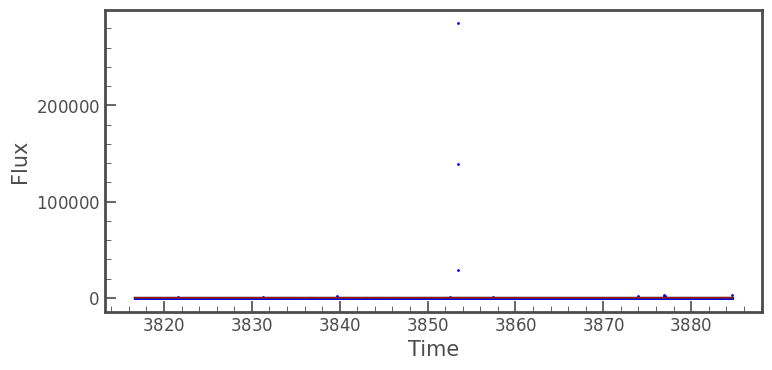

In [28]:
multiwave = specs['waves'];  multiflux=specs['fluxs']
#fig = plt.figure(figsize=(13,4))
#ax = fig.add_subplot(111)
for i in np.arange(multiwave.shape[0])[0:1]:
    #spec = lk.LightCurve(time=multiwave[i],  flux=multiflux[i], flux_err=None)
    spec0 = rmcosimic(specs['waves'][0], specs['fluxs'][0], None, sigma =7, itera=2, percentile_up=99, percentile_low = 0.1, window_length=7, 
              polyorder=2, show=True)
#plt.ylim(0,9000)

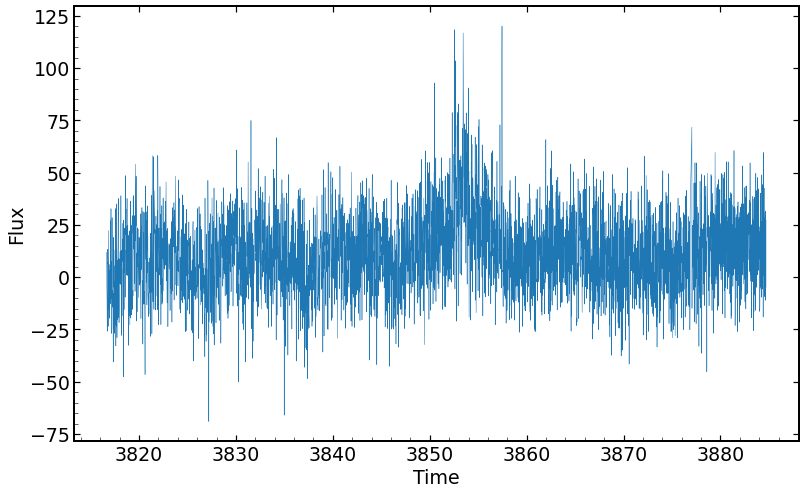

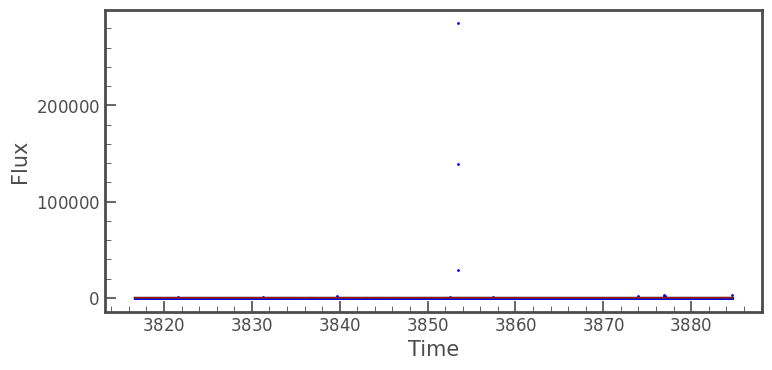

In [29]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111)
for i in np.arange(1):
    rmcosimic(specs['waves'][i], specs['fluxs'][i], None, sigma =7, itera=2, percentile_up=99, percentile_low = 0.1, window_length=7, 
              polyorder=2, show=True)
    spec0.plot(ax = ax)
#plt.ylim(0,2500)

# load TLUSTY for SLAM

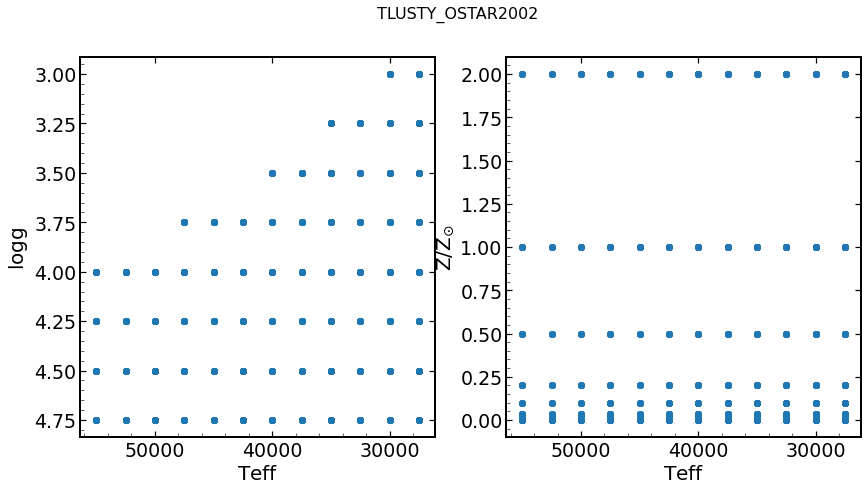

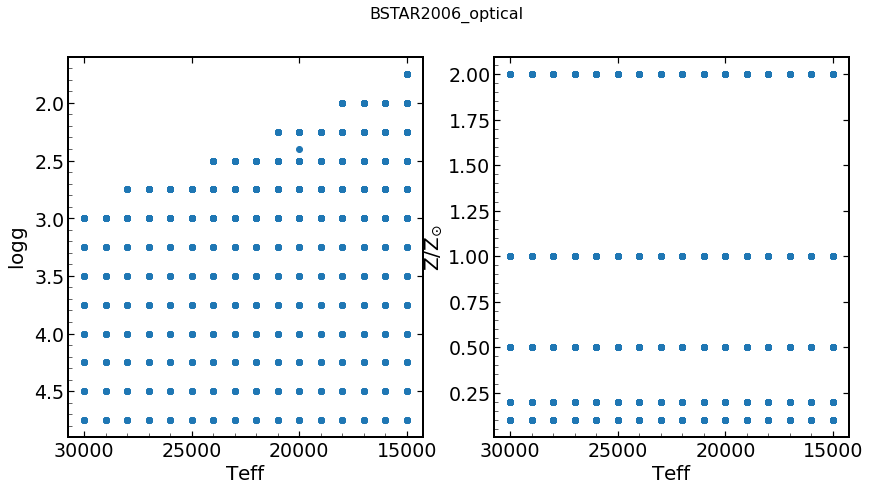

In [14]:
import joblib
from scipy import stats

#TparsG,TlustyG_sps = load('/share/cliu/data/tlusty_specs_allZ.dump')
# TparsG = np.array([teff, logg, z, vt])
OTpars,OTlusty_sps = joblib.load('/media/share/lijiao/TLUSTY_grid/TLUSTY_OSTAR2002_allz.dump')
BTpars,BTlusty_sps = joblib.load('/media/share/lijiao/TLUSTY_grid/BSTAR2006_optical_allz.dump')
# tlusty_hires = []

#for i in range(len(TparsG)):
##         convsp = np.convolve(TlustyG_sps[i][j],s,mode='same')
##         tlusty_hires.append(convsp)
#        convsp = np.convolve(TlustyG_sps[i][j],s2,mode='same')
#        tlusty_lamost.append(convsp)
#        tlusty_pars.append(TparsG[i][j,:])


def plot_parsspace(Tteff, Tlogg, Tz, TVt, figtitle=None):
    fig = plt.figure(figsize=[14, 7])
    if figtitle is not None:
       fig.suptitle(figtitle, fontsize=16)
    axs = fig.subplots(nrows=1, ncols=2)
    axs[0].scatter(Tteff, Tlogg)
    axs[0].set_xlabel(r'$T \rm{eff}$', fontsize=20)
    axs[0].set_ylabel(r'$log \rm{g}$', fontsize=20)
    axs[0].invert_yaxis()
    axs[0].invert_xaxis()
    
    axs[1].scatter(Tteff, Tz)
    axs[1].set_xlabel(r'$T \rm{eff}$', fontsize=20)
    axs[1].set_ylabel(r'$Z/Z_{\odot}$', fontsize=20)
    axs[1].invert_xaxis()
    
    #axs[2].scatter(Tlogg, Tz)
    #axs[2].set_xlabel(r'$log \rm{g}$', fontsize=20)
    #axs[2].set_ylabel(r'$Z/Z_{\odot}$', fontsize=20)
    #axs[2].invert_xaxis()


#Tteff, Tlogg, Tz, TVt =  OTparsG[:, 0], OTparsG[:, 1], OTparsG[:, 2], OTparsG[:, 3]
plot_parsspace(OTpars[:, 0], OTpars[:, 1], OTpars[:, 2], OTpars[:, 3], figtitle='TLUSTY_OSTAR2002')
plot_parsspace(BTpars[:, 0], BTpars[:, 1], BTpars[:, 2], OTpars[:, 3], figtitle='BSTAR2006_optical')

# concatenate TLUSTY_OSTAR2002 and BSTAR2006_optical for TYC 3340-2437-1

- TYC 3340-2437-1
- $27000< T_{\rm eff} < 33000$
- logg < 4.25
- $Z/Z_{\odot}$ > 0.2

TparsG = np.array([teff, logg, z, vt])

In [15]:
from laspec.extern.interpolate import SmoothSpline
def reinterp_wave(ipar, Tpars, Tlusty_sps, wave0, wave, linearinterp=False):
    '''interpolate spectrum in a new wavelength
    parameters:
    ------------------
    ipar [int]
    Tpars [ 2D array] parameters array of TLUSTY grid e.g. np.array([[teff, logg, z, vt]])
    Tlusty_sps [2D array] spectra array of TLUSTY grid
    wave0 [1D array] the original wavelength of TLUSTY spectra
                     e.g. BTLUSTY optical: wave = np.arange(3200.01, 9998.7, 0.01); 
                          OTLUSTY: wave = np.arange(3000, 7500, 0.01)
    wave [1D array] the new wavelength
    returns:
    -------------
    pars [1D array] which has the same parameters with Tpars
    spec [1D array] has same length as wave
    '''
    #print(len(Tlusty_sps[ipar]), len(wave0))
    if linearinterp:
        spec = np.interp(wave, wave0, Tlusty_sps[ipar])
    else:
        func = SmoothSpline(wave0, Tlusty_sps[ipar], p=1)
        spec = func(wave)
    return Tpars[ipar], spec
    


_Oind = np.where((OTpars[:, 0] <= 33000) & (OTpars[:, 1] <= 4.25) & (OTpars[:, 2] >= 0.02))[0]
_Bind = np.where((BTpars[:, 0] < 27000) & (BTpars[:, 0] >= 29000) & (BTpars[:, 1] <= 4.24) & (BTpars[:, 2] >= 0.02))[0]
print(f'Number of OTLUSTY {len(_Oind)} and BTLUSTY {len(_Bind)}')

    
wavelength = np.arange(3201, 7499, 0.01)
_Owave0 = np.arange(3000, 7500, 0.01)
_Bwave0 = np.arange(3200.01, 9998.7, 0.01)


_Otlusty = joblib.Parallel(n_jobs=10, )(joblib.delayed(reinterp_wave)(ipar, OTpars,OTlusty_sps, _Owave0, wavelength) for ipar in tqdm(_Oind))
_Btlusty = joblib.Parallel(n_jobs=10, )(joblib.delayed(reinterp_wave)(ipar, BTpars,BTlusty_sps, _Bwave0, wavelength) for ipar in tqdm(_Bind))

tlusty_OB = _Otlusty + _Btlusty

  0%|          | 0/119 [00:00<?, ?it/s]

Number of OTLUSTY 119 and BTLUSTY 0


100%|██████████| 119/119 [00:07<00:00, 15.12it/s]
0it [00:00, ?it/s]


In [16]:
del OTpars,OTlusty_sps, BTpars,BTlusty_sps

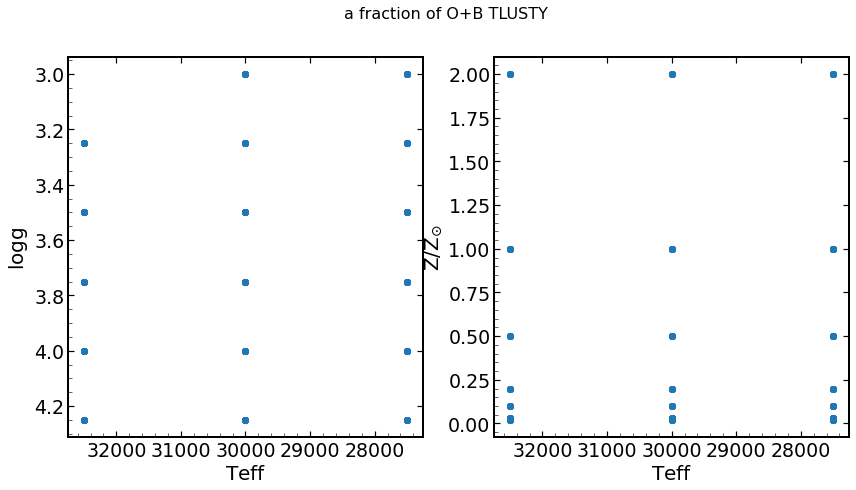

In [17]:
Tpars = []
Tlusty_sps = []
for itl in tlusty_OB:
    Tpars.append(itl[0])
    Tlusty_sps.append(itl[1])
    
Tpars = np.array(Tpars)
Tlusty_sps = np.array(Tlusty_sps)
Tteff, Tlogg, Tz, Tvt = Tpars[:, 0],Tpars[:, 1],Tpars[:, 2],Tpars[:, 3]

# check parametes space of tlusty_pars
plot_parsspace(Tpars[:, 0], Tpars[:, 1], Tpars[:, 2], Tpars[:, 3], figtitle='a fraction of O+B TLUSTY')

# broad tlusty spectum (specrtum resolution)

<Figure size 1080x1080 with 0 Axes>

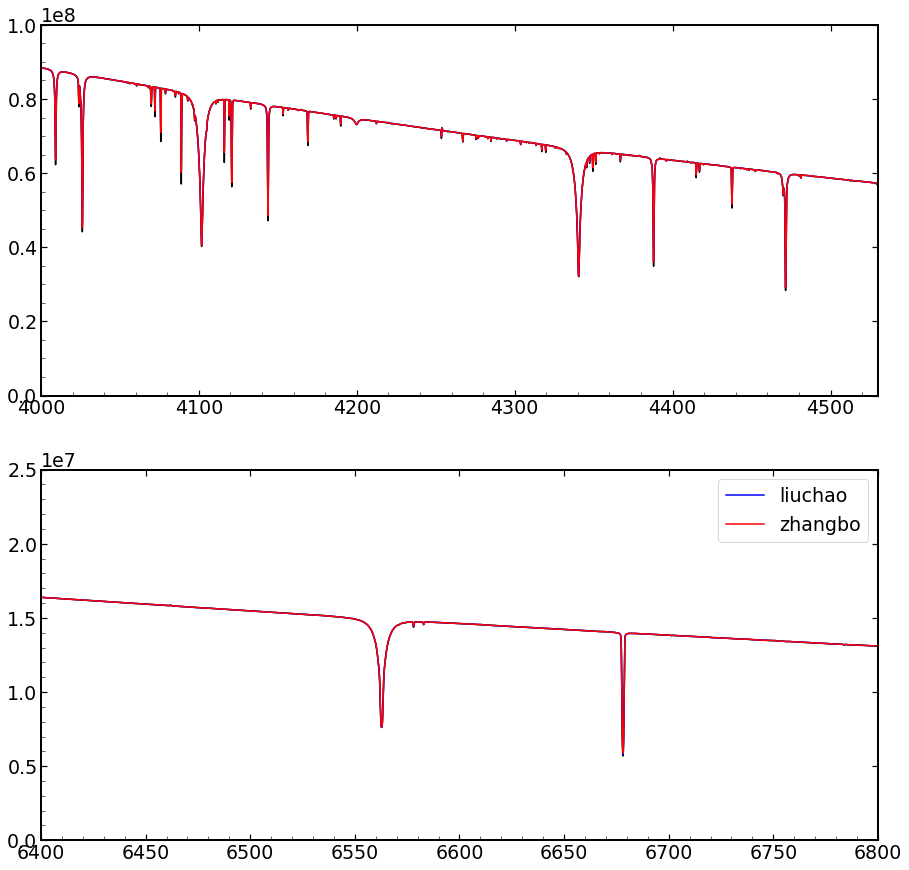

In [18]:
from laspec import convolution

def broad_tlusty(ipar, pix=0.01, mwv= 4861, R = 20000, pars=Tpars, sps=Tlusty_sps, wave=None, laspec_conv=False):
    '''broad tlusty spectrum with a resolution
    parameters:
    ------------------
    ipar [int]
    pix [float] the sample interval of spectra
    mwv [float] the median (or mean) wavelength of spectrum which is used to caculate the gaussian window by resoution
    R [float] spectrum resolution which we want to get
    Tpars [ 2D array] parameters array of TLUSTY grid e.g. np.array([[teff, logg, z, vt]])
    Tlusty_sps [2D array] spectra array of TLUSTY grid
    wave0 [1D array] the original wavelength of TLUSTY spectra
                     e.g. BTLUSTY optical: wave = np.arange(3200.01, 9998.7, 0.01); 
                          OTLUSTY: wave = np.arange(3000, 7500, 0.01)
    wave [1D array] the new wavelength
    returns:
    -------------
    pars [1D array] which has the same parameters with Tpars
    spec [1D array] has same length as wave
    '''
    flux = sps[ipar]
    if laspec_conv:
       if wave is None: wave  =  nnp.arange(3201, 7499, 0.01)
       wv_new, convsp = convolution.conv_spec(wave, flux, R_hi=300000., R_lo=R, over_sample_additional=1,
              gaussian_kernel_sigma_num=5., wave_new=wave,
              wave_new_oversample=1, verbose=False, return_type='array')
    else:
        fwhm = mwv/R
        sigma =  fwhm / (2.0 * np.sqrt(2. * np.log(2.)))
        nn2 = sigma/pix
        x = np.arange(-nn2*2,nn2*2+1,1)
        s2 = stats.norm.pdf(x,0,nn2)
        s = s2/np.sum(s2)
        convsp = np.convolve(flux,s,mode='same')
    return Tpars[ipar], convsp

# campare broaded spectrum with the tlusty origial spectrum

ipar = 1
wave = np.arange(3201, 7499, 0.01)
_tparas, _convsp = broad_tlusty(ipar, pix=0.01, mwv= 4861, R = 20000,pars=Tpars, sps=Tlusty_sps, laspec_conv=False)
_tparas1, _convsp1 = broad_tlusty(ipar, pix=0.01, mwv= 4861, R = 20000,pars=Tpars, sps=Tlusty_sps, wave=wave, laspec_conv=True)
fig = plt.figure(figsize=[15,15])
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(211)
ax.plot(wave, Tlusty_sps[ipar], 'k')
ax.plot(wave, _convsp, 'b', label='liuchao')
ax.plot(wave, _convsp1, 'r', label='zhangbo')
ax.set_xlim(6400, 6800)
ax.set_ylim(0, 0.25e8)
ax.set_xlim(4000,4530)
ax.set_ylim(0, 1.e8)

ax = fig.add_subplot(212)
ax.plot(wave, Tlusty_sps[ipar], 'k')
ax.plot(wave, _convsp, 'b', label='liuchao')
ax.plot(wave, _convsp1, 'r', label='zhangbo')
ax.set_xlim(6400, 6800)
ax.set_ylim(0, 0.25e8)
ax.set_xlim(6400, 6800)
ax.set_ylim(0, 0.25e8)
plt.legend()

diffwv = 0.023446643187526206


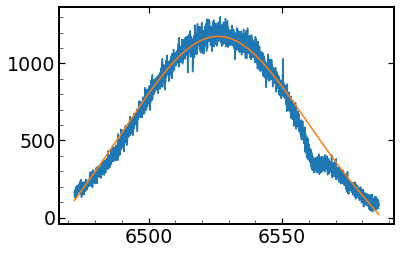

In [74]:
_i = 64
spec0 = rmcosimic(multiwave[_i], multiflux[_i], None, sigma =7, itera=2,  percentile_up=99, percentile_low = 0.01,window_length=21, 
              polyorder=2, show=False)

flux_norm, flux_smoothed2 =lanorm.normalize_spectrum_spline(spec0.time, spec0.flux, p=8.e-6, q=0.5, lu=(-1, 3), binwidth=300,
                                      niter=5)



plt.plot(spec0.time, spec0.flux)
plt.plot(spec0.time, flux_smoothed2 )
print(f'diffwv = {np.min(np.diff(multiwave[64:66], axis=1))}')

# binning spectrum

- binning law

$\lambda = 10^x$

$\lambda^\prime = ln(10) 10^x$

$\frac{\Delta \lambda}{\lambda} = ln(10)\Delta x$  & $R =  \frac{\lambda}{\Delta \lambda} $--> $\Delta x = \frac{1}{Rln(10)*n}$

10097.939977754051
wave_min= 3816.6567697122823, wave_max = 10098.327635965892
[0.01396205 0.01404935 0.0141378  0.01422744 0.01431828 0.01441035
 0.01450368 0.01459828 0.0146942  0.01479144 0.01489004 0.01499002
 0.01509142 0.01519427 0.01529859 0.01540441 0.01551177 0.0156207
 0.01573124 0.01584341 0.01595726 0.01607282 0.01619013 0.01630923
 0.01643016 0.01655296 0.01667767 0.01680434 0.01693301 0.01706373
 0.01719656 0.01733153 0.0174687  0.01760812 0.01774985 0.01789395
 0.01804048 0.01818949 0.01834104 0.01849521 0.01865206 0.01881166
 0.01897408 0.0191394  0.01930769 0.01947904 0.01965352 0.01983123
 0.02001224 0.02019666 0.02038459 0.02057611 0.02077133 0.02097036
 0.02117332 0.02138031 0.02159147 0.02180691 0.02202676 0.02225116
 0.02248026 0.0227142  0.02295314 0.02319723 0.02344664 0.02370156
 0.02396215 0.02422862 0.02450116 0.02477998 0.0250653  0.02535735
 0.02565636 0.0259626  0.02627632 0.0265978  0.02692734 0.02726522
 0.02761179 0.02796737 0.02833231 0.02870701 0.0290

(6202.554893079347, 6311.808218342494)

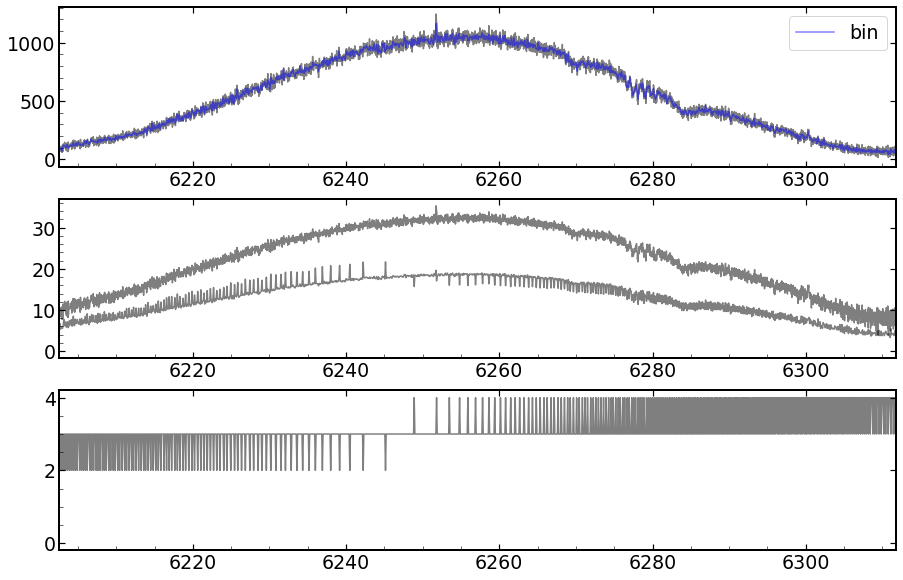

In [40]:
def rmcosimics(waves, fluxs, fluxerrs):
    for _i, wave in enumerate(waves):
        flux = fluxs[_i].copy()
        fluxerr = fluxerrs[_i].copy()
        lc = rmcosimic(wave, flux, fluxerr, sigma =5, itera=2,\
                       percentile_up=95, percentile_low=0.01,window_length=7,\
                       polyorder=2, show=False)
        waves[_i] = lc.time
        fluxs[_i] = lc.flux
        fluxerrs[_i] = lc.flux_err
    return waves, fluxs, fluxerrs


def binning_spectrum(waves, fluxs, flux_errs, wave_bin=np.arange(3574, 8940, 0.8)):
    '''binning the spectrum
    
    parameters
    -------------------
    waves [2D array]
    fluxs [2D array]
    flux_errs [2D array]
    return:
    --------------------
    wave_new [2D array]
    flux_bin [2D array]
    fluxerr_bin [2D array]
    n [2D array]
    '''
    norder = waves.shape[0]
    wave = (wave_bin[1:] + wave_bin[:-1])/2.
    nwvl = len(wave)
    wave_new = np.zeros((norder, nwvl))
    flux_bin = np.zeros((norder, nwvl))
    fluxerr_bin = np.zeros((norder, nwvl))
    n = np.zeros((norder, nwvl))
    for _i, _wave in enumerate(waves):
        _flux = fluxs[_i]
        _fluxerr2 = flux_errs[_i]**2
        _fluxerr2_bin,_ = np.histogram(_wave, bins=wave_bin, weights=_fluxerr2)
        _flux_bin,_ = np.histogram(_wave, bins=wave_bin, weights=_flux)
        _n,_ = np.histogram(_wave, bins=wave_bin)
        flux_bin[_i] = _flux_bin/_n
        fluxerr_bin[_i] =  np.sqrt(_fluxerr2_bin)/_n
        wave_new[_i] = wave
        n[_i] = _n
    _ind = np.isnan(flux_bin)
    flux_bin[_ind] = 0.
    fluxerr_bin[_ind] = 0.
    return  wave_new, flux_bin, fluxerr_bin, n
    

_waves = specs['waves']
_fluxs = specs['fluxs']



waves, fluxs, fluxerrs = rmcosimics(_waves, _fluxs, _flux_errs)
flux_errs = np.sqrt(fluxs)

resolution = 30000
deltax = 1/resolution/np.log(10)/2.5 # 2.5 is the sampling
wave_bin = 10**np.arange(np.log10(3817), np.log10(10098), deltax)
wave = (wave_bin[1:] + wave_bin[:-1])/2.

print(np.max(wave_bin))

print(f'wave_min= {np.min(waves)}, wave_max = {np.max(waves)}')
print(np.min(np.diff(waves, axis=1), axis=1))
print(np.max(np.diff(waves, axis=1), axis=1))

wave_new, flux_bin, fluxerr_bin, _n = binning_spectrum(waves, fluxs, flux_errs, wave_bin=wave_bin)
_i = 60
_wave, _flux, _flux_err = waves[_i], fluxs[_i], flux_errs[_i]
fig,axs = plt.subplots(3,1, figsize=(15,10))
plt.sca(axs[0])
plt.plot(_wave, _flux, 'k', alpha=0.5)
plt.plot(wave_new[_i], flux_bin[_i], 'b', alpha=0.5, label='bin')
plt.xlim(_wave.min(), _wave.max())
plt.legend()
#plt.xlim(4100, 4200)
plt.sca(axs[1])
plt.plot(_wave, _flux_err, 'k', alpha=0.5)
plt.plot(wave, fluxerr_bin[_i], 'k', alpha=0.5)
plt.xlim(_wave.min(), _wave.max())

plt.sca(axs[2])
plt.plot(wave, _n[_i], 'k', alpha=0.5)
plt.xlim(_wave.min(), _wave.max())


### split joint the spectra

(97, 4096)


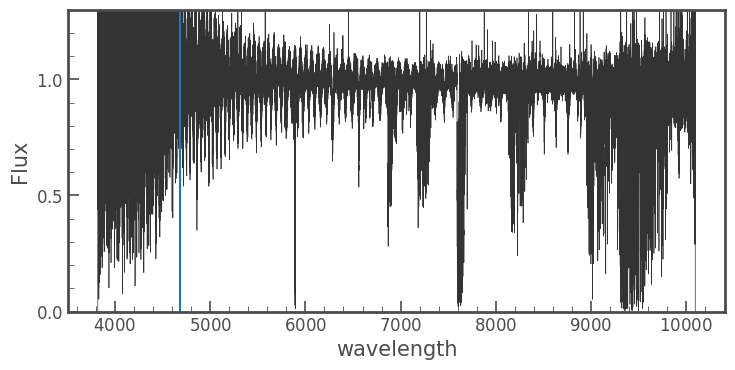

In [94]:
def combine_spectrum_max(waves, fluxs, flux_errs, wave_dens=None, speclist=None, show=True):
    '''combine spectra of E9+G10 with the maxium ADU
    parameters
    -----------
    waves [2D array] e.g. waves.shape = (11, 2048)
    fluxs [2D array] same as the waves.shape
    flux_errs [2D array] same as the waves.shape
    wave_dens [1D array]
    speclist [1D array of list] the indices of spectra; e.g. [0, 1, 2, 3]
    
    return
    -----------
    wave_dens [1D array] the wavelength of the combine spectrum
    flux_norm [1D array] the normalized flux of combined spectrum
    flux_err [1D array] the flux error of combined spectrum
    '''
    if speclist is None: speclist = np.arange(waves.shape[0])
    if wave_dens is None:
       delta_wv = 0.1#np.min(np.diff(waves, axis=1))
       wv_min, wv_max= np.min(waves), np.max(waves)
       wave_dens = np.arange(wv_min, wv_max, delta_wv)
    else: delta_wv = np.median(np.diff(wave_dens))
    
    
    N_wv = len(wave_dens)
    fluxs_dens = np.zeros((fluxs.shape[0], N_wv))
    _fluxnorms_dens = np.zeros((fluxs.shape[0], N_wv))
    fluxnorms_dens = np.zeros((fluxs.shape[0], N_wv))
    _fluxerrs2_dens = np.zeros((fluxs.shape[0], N_wv))
    fluxerrs2_dens = np.zeros((fluxs.shape[0], N_wv))
    #waves_dens = np.zeros((fluxs.shape[0], N_wv))
    
    
    for fluxi in speclist:
        #spec0 = rmcosimic(waves[fluxi], fluxs[fluxi], flux_errs[fluxi], sigma =5, itera=2, percentile_up=94, percentile_low=0.01,window_length=7, polyorder=2, 
        #                  show=False)
        #### norlize spectrum
        #flux_norm, flux_smoothed2 =lanorm.normalize_spectrum_spline(spec0.time, spec0.flux, p=1E-6, q=0.5, lu=(-1, 3), binwidth=30,
        #                              niter=5)
        ind = fluxs[fluxi] > 0
        _wave, _flux, _fluxerr = waves[fluxi][ind], fluxs[fluxi][ind],  flux_errs[fluxi][ind]
        flux_norm, flux_smoothed2 =lanorm.normalize_spectrum_spline(_wave, _flux, p=4E-6, q=0.5, lu=(-1, 3), binwidth=30,
                                      niter=5)
        fluxs_dens[fluxi] = np.interp(wave_dens, _wave[50:-50], _flux[50:-50], right=0., left=0.)
        _fluxnorms_dens[fluxi] = np.interp(wave_dens, _wave[50:-50], flux_norm[50:-50], right=0., left=0.)
        err_frac = np.append(1, np.diff(_wave)/delta_wv)
        #print(f'{fluxi}; len(err_frac)= {len(err_frac)}, len(_fluxerr) = {len(_fluxerr**2)}')
        err2_tmp = _fluxerr**2*err_frac
        _fluxerrs2_dens[fluxi] = np.sqrt(np.interp(wave_dens, _wave, err2_tmp/flux_smoothed2**2, right=0., left=0.))
        #waves_dens[fluxi] = wave_dens
        if False:
           #ax = spec.scatter(color='b')
           #spec0.plot(ax=ax)
           #ax.plot(spec0.time, flux_smoothed2)
           fig = plt.figure(figsize=(14,5))
           plt.plot(waves[fluxi], flux_norm)
           pltmod =[plt.plot(rvm.wave_mod, _+0.01*__) for __, _ in enumerate(rvm.flux_mod[0:1])]
           plt.xlabel('wavelength')
           plt.plot(wave_dens, _fluxnorms_dens[fluxi])
           plt.xlim(waves[fluxi][0], waves[fluxi][-1])
    
    #return fluxs_dens, fluxnorms_dens
    flx = np.max(fluxs_dens, axis=0)
    ind = fluxs_dens == np.array(list(flx)*fluxs_dens.shape[0]).reshape(fluxs_dens.shape)
    fluxnorms_dens[ind] = _fluxnorms_dens[ind]
    flux_norm = np.sum(fluxnorms_dens, axis=0)/np.sum(ind, axis=0)
    fluxerrs2_dens = _fluxerrs2_dens[ind]
    flux_err = np.sqrt(np.sum(fluxerrs2_dens, axis=0)/np.sum(ind, axis=0))
    #flux_err = fluxerrs_dens[ind]
    #wave_dens = waves_dens[ind]
    #ind_sort = np.argsort(wave_dens)
    #wave_dens = wave_dens[ind_sort]
    #flux_norm = flux_norm#[ind_sort]
    #flux_err = flux_err#[ind_sort]
  
    # renormalize joint spectrum
    #return wave_dens, flux_norm
    _fluxnorm, _flux_smoothed =lanorm.normalize_spectrum_spline(wave_dens, flux_norm)
    _flux_err = flux_err/_flux_smoothed
    if show:
       spec = lk.LightCurve(time=wave_dens,  flux=flux_norm, flux_err=None)
       spec.plot()
       plt.xlabel('wavelength')
       plt.ylim(0, 1.3)
    return wave_dens, flux_norm, flux_err


_waves = specs['waves']
_fluxs = specs['fluxs']
_flux_errs = np.sqrt(_fluxs)
waves, fluxs, fluxerrs = rmcosimics(_waves, _fluxs, _flux_errs)
print(fluxs.shape)

wave, flux, flux_err = combine_spectrum_max(waves, fluxs, fluxerrs, speclist=None, show=True)
#plt.xlim(6340, 6450)
plt.axvline(x=4686)

(2, 1702)


Text(0.5, 1.0, 'joint by maximum flux')

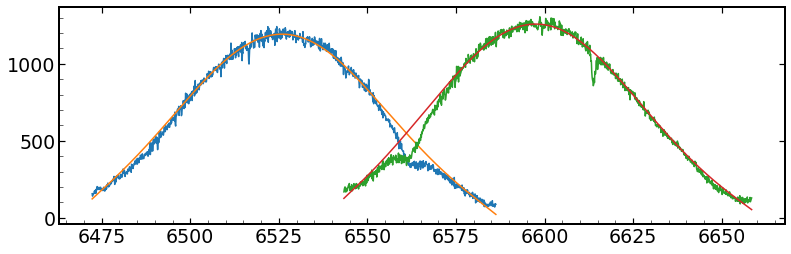

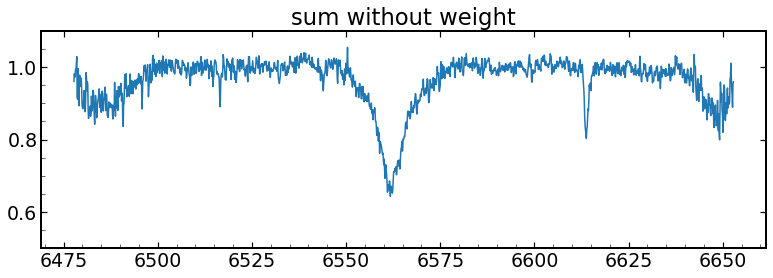

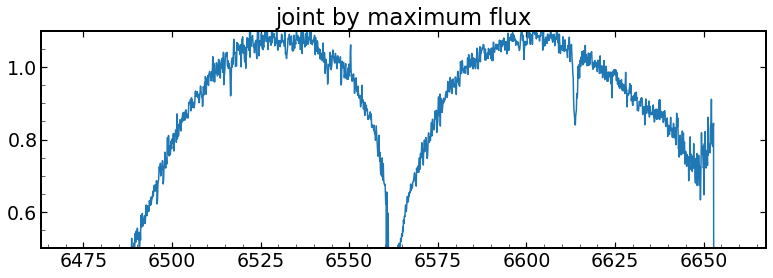

In [93]:
def combine_spectrum_sum(waves, fluxs, flux_errs, wave_dens=None, speclist=None, show=False):
    '''combine spectra of E9+G10 by summing the overlap zone
    page 28 of specnan2014
    parameters
    -----------
    waves [2D array] e.g. waves.shape = (11, 2048)
    fluxs [2D array] same as the waves.shape
    flux_errs [2D array] same as the waves.shape
    speclist [1D array of list] the indices of spectra; e.g. [0, 1, 2, 3]
    weight [bool] sum with weight
    return
    -----------
    wave_dens [1D array] the wavelength of the combine spectrum
    flux_norm [1D array] the normalized flux of combined spectrum
    flux_err [1D array] the flux error of combined spectrum
    '''
    if speclist is None: speclist = np.arange(waves.shape[0])
    if wave_dens is None:
       delta_wv = 0.1#np.min(np.diff(waves, axis=1))
       wv_min, wv_max= np.min(waves), np.max(waves)
       wave_dens = np.arange(wv_min, wv_max, delta_wv)
    

    delta_wv = np.median(np.diff(np.log10(wave_dens)))
    
    speclist = np.arange(waves.shape[0])
    N_wv = len(wave_dens)
    fluxs_dens = np.zeros((fluxs.shape[0], N_wv))
    fluxnorms_dens = np.zeros((fluxs.shape[0], N_wv))
    fluxerr2s_dens = np.zeros((fluxs.shape[0], N_wv))
    smoothed_dens = np.zeros((fluxs.shape[0], N_wv))
    waves_dens = np.zeros((fluxs.shape[0], N_wv))
    fig = plt.figure(figsize=(13,4))
    for fluxi in speclist:
        ind = fluxs[fluxi] > 0
        _wave, _flux, _fluxerr = waves[fluxi][ind], fluxs[fluxi][ind],  flux_errs[fluxi][ind]
        
        flux_norm, flux_smoothed2 =lanorm.normalize_spectrum_spline(_wave, _flux, p=1.e-4, q=0.5, lu=(-1, 3), binwidth=10,
                                      niter=5)
        plt.plot( _wave, _flux)
        plt.plot(_wave, flux_smoothed2)

        fluxs_dens[fluxi] = np.interp(wave_dens, _wave[50:-50], _flux[50:-50], right=0., left=0.)
        smoothed_dens[fluxi] = np.interp(wave_dens,  _wave[50:-50], flux_smoothed2[50:-50], right=0., left=0.)
        #fluxnorms_dens[fluxi] = np.interp(wave_dens, spec0.time[50:-50], flux_norm[50:-50], right=0., left=0.)
        err_frac = np.append(1, np.diff(np.log10(_wave))/delta_wv)
        #print(delta_wv)
        
        err2_tmp =  _fluxerr**2*err_frac
        #print(np.median(err_frac))
        fluxerr2s_dens[fluxi] = np.interp(wave_dens, _wave[50:-50], err2_tmp[50:-50], right=0., left=0.)
        waves_dens[fluxi] = wave_dens
   
    fracs = 1./np.sum(fluxs_dens > 0, axis=0)
    fracs[np.isinf(fracs)] = 0.
    #fluxnorm_sum = np.sum(fluxnorms_dens*fracs, axis=0)
    _fluxs_sum = np.sum(fluxs_dens*fracs, axis=0)
    #print(np.sum(_fluxs_sum))
    _smooth_sum = np.sum(smoothed_dens*fracs, axis=0)
    _fluxerr2s_sum = np.sum(fluxerr2s_dens*fracs**2, axis=0)
    _fluxnorm_sum = _fluxs_sum/_smooth_sum
    _fluxnorm_err = np.sqrt(_fluxerr2s_sum)/_smooth_sum
    #_fluxnorm_err = np.sqrt(_fluxs_sum)/_smooth_sum
    #_fluxnorm_err = np.sqrt(_fluxs_sum)/_smooth_sum
    #return wave_dens, _fluxnorm_sum
    # renormalize joint spectrum
    #fluxnorm_sum, _flux_smoothed2 =lanorm.normalize_spectrum_spline(wave_dens, _fluxnorm_sum)
    #fluxnorm_err = _fluxnorm_err/_flux_smoothed2
    if show:
       spec = lk.LightCurve(time=wave_dens,  flux=fluxnorm_sum, flux_err=None)
       spec.plot()
       plt.xlabel('wavelength')
       plt.ylim(0, 1.3)
    return wave_dens, _fluxnorm_sum, _fluxnorm_err



_waves = specs['waves'][64:66]
_fluxs = specs['fluxs'][64:66]
_flux_errs = np.sqrt(_fluxs)

waves, fluxs, fluxerrs = rmcosimics(_waves, _fluxs, _flux_errs)
fluxerrs = np.sqrt(fluxs)
flux_errs = np.sqrt(fluxs)

resolution = 30000
deltax = 1/resolution/np.log(10)/2
wave_bin = 10**np.arange(np.log10(np.min(waves)), np.log10(np.max(waves)), deltax)
wave = (wave_bin[1:] + wave_bin[:-1])/2.
#print(wave/np.diff(wave_bin))

waves, fluxs, flux_errs, _n = binning_spectrum(waves, fluxs, flux_errs, wave_bin=wave_bin)


#### combine spectra by summing the overlap zones without weight
print(waves.shape)
wave_dens, fluxnorm_sum, fluxnorm_err = combine_spectrum_sum(waves, fluxs, flux_errs, wave_dens=wave_bin, speclist=None)
fig = plt.figure(figsize=(13,4))
plt.plot(wave_dens, fluxnorm_sum)
#pltmod =[plt.plot(rvm.wave_mod, _+0.01*__) for __, _ in enumerate(rvm.flux_mod[0:1])]
d = 5000
#plt.xlim(d, d+100)
#plt.xlim(5500, 6000)
plt.ylim(0.5, 1.1)
plt.title('sum without weight')

#### combine spectra by selecting the max flux at overlop zones
wave_max, flux_max, fluxerr_max = combine_spectrum_max(waves, fluxs, flux_errs, speclist=None, show=False)
fig = plt.figure(figsize=(13,4))
plt.plot(wave_max, flux_max)
#pltmod =[plt.plot(rvm.wave_mod, _+0.01*__) for __, _ in enumerate(rvm.flux_mod[0:1])]
#plt.xlim(d, d+100)
#plt.xlim(5500, 6000)
plt.ylim(0.5, 1.1)
plt.title('joint by maximum flux')



In [67]:
_waves.shape, wave_bin.shape

((2, 4096), (2129,))

### calculate hjd, bjd, and [Radial Velocity Corrections](https://docs.astropy.org/en/stable/coordinates/velocities.html)

In [88]:
from astropy.time import Time
from PyAstronomy import pyasl
from astropy import coordinates as coord
def eval_ltt(ra=62.794724868, dec=50.7082235439, jd=2456326.4583333, site=None, kind='barycentric', barycorr=True):                                                                                                            
    """ evaluate the jd 
    parameters
    ----------
    ra, dec: the coordinate of object
    jd: the julian date of observation (UTC time)
    site: the site of observatory
    return
    ------
    jd_llt: the bjd of hjd
    ltt: light_travel_time
    if barycorr=True return the barycentric correction
    """
    # conf: https://docs.astropy.org/en/stable/time/
    # defaut site is Xinglong
    # coord.EarthLocation.from_geodetic(lat=26.6951*u.deg, lon=100.03*u.deg, height=3200*u.m) lijiang
    if site is None:
        site = coord.EarthLocation.of_site('Beijing Xinglong Observatory')
    # sky position
    ip_peg = coord.SkyCoord(ra, dec, unit=(units.deg, units.deg), frame='icrs')
    # time
    times = Time(jd, format='jd', scale='utc', location=site)
    # evaluate ltt
    ltt = times.light_travel_time(ip_peg,kind)
    jd_llt = times.utc + ltt
    if barycorr is True:
       _barycorr = ip_peg.radial_velocity_correction(obstime=Time(times.iso), location=site)
       return jd_llt.jd, ltt, _barycorr
    else:
       return jd_llt.jd, ltt


def rvcorr_spec(wave, flux, fluxerr, rv, wave_new=None, left=np.nan, right=np.nan, interp1d=None):
    ''' correct spectrum with radial velocity
    parameters:
    ------------
    wave [1d array]
    flux [1d array]
    fluxerr [1d array]
    barycorr [float] barycentric radial velocity in units of km/s
    
    returns:
    ----------
    flux_bc [1d array]
    fluxerr_bc [1d array]
    '''
    wvl = wave
    flux = flux
    ## Page 71 of An Introduction to Close Binary Stars
    c = 299792.458
    beta = rv/c
    lgwvl = np.log(wvl)
    gamma =(1+beta)/(1-beta)
    _lgwvl = lgwvl + 0.5*np.log(gamma)
    
    if wave_new is None:
       lgwvl = np.log(wvl)
    else: lgwvl = np.log(wave_new)
    if interp1d is None:
       flux_bc = np.interp(lgwvl, _lgwvl, flux, left=left, right=right)
       err2 = np.interp(lgwvl, _lgwvl, fluxerr**2, left=left, right=right)
    else:
       flux_bc = interp1d(_lgwvl, flux, kind='linear',fill_value='extrapolate')(lgwvl)
       err2 = interp1d(_lgwvl, fluxerr**2, kind='linear',fill_value='extrapolate')(lgwvl)
    fluxerr_bc = np.sqrt(err2)
    return flux_bc, fluxerr_bc

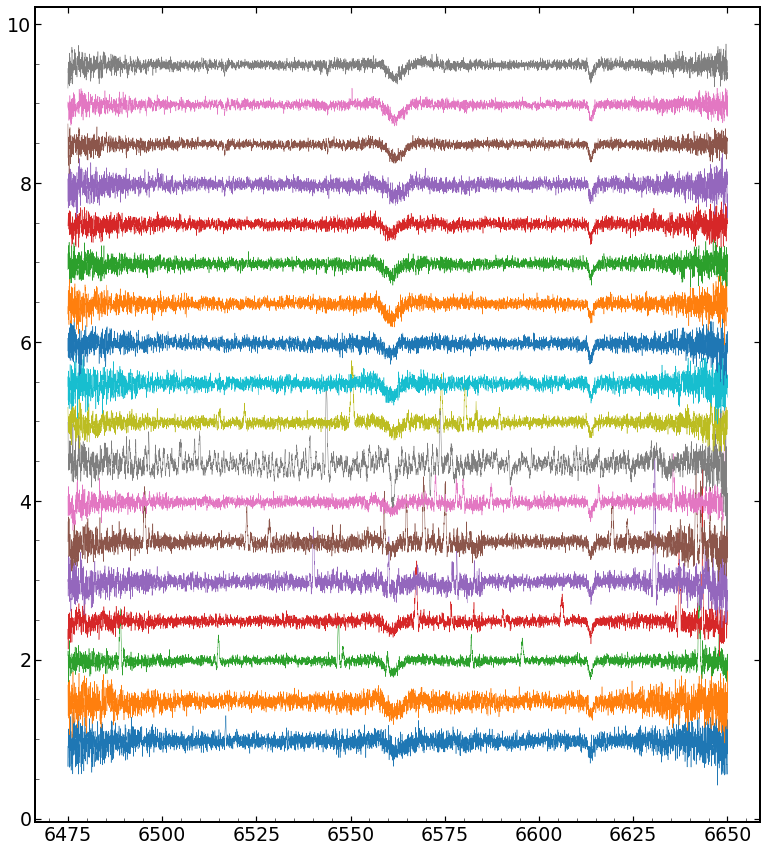

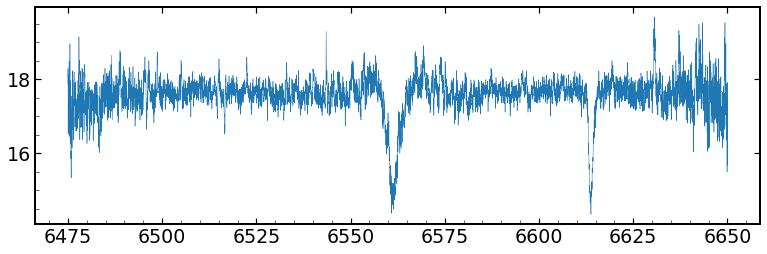

In [26]:
n_filename = len(filenames)

wave_dens = np.arange(6475, 6650, 0.02)
flux_dens = np.zeros(wave_dens.shape)

fig = plt.figure(figsize=(13,15))
ax = fig.add_subplot(1,1,1)
for _i, _fname in enumerate(filenames):
   specs = multispec(_fname)
   waves = specs['waves'][64:66]
   fluxs = specs['fluxs'][64:66]
   flux_errs = np.sqrt(fluxs) 
   wave_dens, fluxnorm_sum, fluxnorm_err = combine_spectrum_sum(waves, fluxs, flux_errs, wave_dens=wave_dens, speclist=None)
   flux_dens += fluxnorm_sum
   plt.plot(wave_dens, fluxnorm_sum+_i*0.5, lw=0.5)

fig = plt.figure(figsize=(13,4))
ax = fig.add_subplot(1,1,1)
plt.plot(wave_dens, flux_dens, lw=0.5)

# check the resolution of 240cm HRS

(0.5, 1.4)

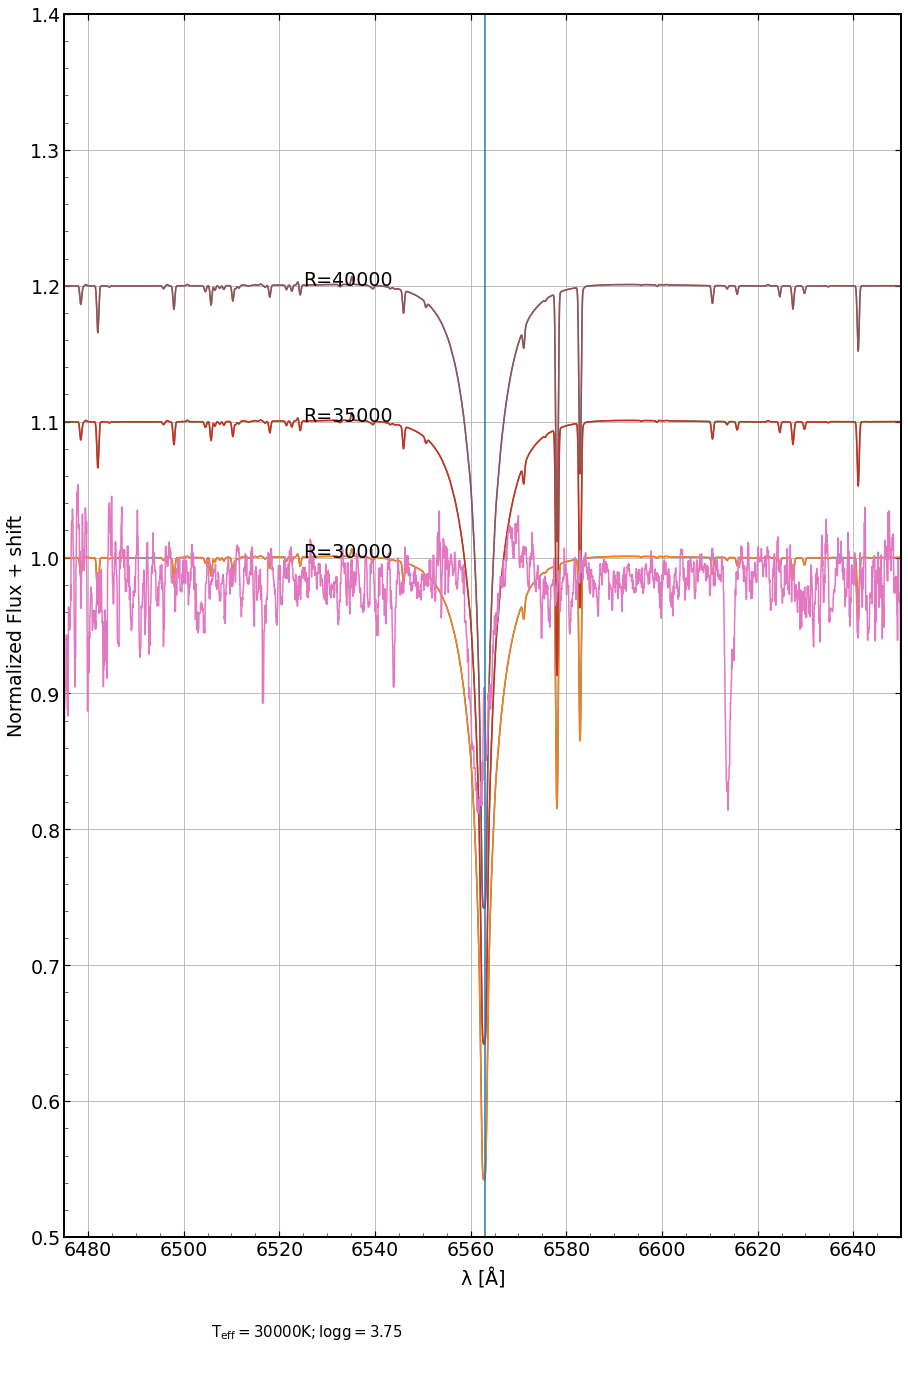

In [27]:
from scipy.signal import medfilt
wvl = np.arange(3600, 8850, 0.1)
ipar = np.where((Tpars[:, 0] == 30000) & (Tpars[:, 1] == 4.00) & (Tpars[:, 2] == 1.))[0][0]
#_tparas, _convsp = broad_tlusty(ipar, pix=0.01, mwv= 4861, R = 2000, pars=Tpars, sps=Tlusty_sps)

wave = np.arange(3201, 7499, 0.01)
_wave = np.arange(3500, 7499, 0.01)

fig, axs = plt.subplots(1,1,figsize=(15, 22.5))
for _i, R in enumerate([30000, 35000, 40000]):
    _, _flux = broad_tlusty(ipar, pix=0.01, mwv= 4861, R = R,pars=Tpars, sps=Tlusty_sps, wave=wave, laspec_conv=True)
    _flux = np.interp(_wave, wave, _flux)
    _nflux = lanorm.normalize_spectrum_spline(_wave, _flux)
    axs.plot(_wave, _nflux[0]+_i*0.1)
    _y = np.interp(6525, _wave, _nflux[0]+_i*0.1)
    axs.text(6525, _y, f'R={R}')
    axs.plot(_wave, _nflux[0]+_i*0.1)
    

axs.text(0.13, 0.1, r'$T_{\rm eff} = 30000 K; logg = 3.75$', transform=ax.transAxes, fontsize=15)


_fluxnorm_sum = medfilt(fluxnorm_sum,kernel_size=21 ) 
plt.plot(wave_dens, _fluxnorm_sum)
plt.axvline(x= 6563)
plt.grid(True)
plt.xlabel("$\\lambda~[\\mathrm{\AA}]$")
plt.ylabel("Normalized Flux + shift")
plt.xlim(6475,6650)
plt.ylim(0.5, 1.4)

In [29]:
wave = np.arange(3201, 7499, 0.01)
_N_Tpars = np.arange(len(Tpars))
tlusty_lamosts0 = joblib.Parallel(n_jobs=10, )(joblib.delayed(broad_tlusty)(ipar, pix=0.01, mwv= 4861, R = 30000,pars=Tpars, sps=Tlusty_sps, wave=wave, laspec_conv=True) for ipar in tqdm(_N_Tpars))

tlusty_lamost0 = []
tlusty_pars0 = []
for itl in tlusty_lamosts0:
    tlusty_lamost0.append(itl[1])
    tlusty_pars0.append(itl[0])
    
tlusty_lamost0 = np.array(tlusty_lamost0)
tlusty_pars0 = np.array(tlusty_pars0)
    

wave_new = np.arange(3201, 7499, 0.01)
    
tlusty_lamosts = joblib.Parallel(n_jobs=20, )(joblib.delayed(reinterp_wave)(ipar, tlusty_pars0, tlusty_lamost0, wave, wave_new, linearinterp=True) for ipar in tqdm(_N_Tpars))


tlusty_lamost = []
tlusty_pars = []
for itl in tlusty_lamosts:
    tlusty_lamost.append(itl[1])
    tlusty_pars.append(itl[0])
    
tlusty_lamost = np.array(tlusty_lamost)
tlusty_pars = np.array(tlusty_pars)

100%|██████████| 119/119 [00:01<00:00, 93.55it/s]


In [32]:
# normalize the synthesis spectra with resolution of 30000 and create radial velocity model
from laspec.ccf import RVM

def normalize_template(ipar, wvl, pars, sps):
    '''Apply rotational broadening to a spectrum. The formulae given in Gray's "The Observation
       and Analysis of Stellar Photospheres". 
       
    parameters:
    ------------------
    ipar [int]
    vsini : [float]
        Projected rotational velocity [km/s].
    epsilon : [float]
        Linear limb-darkening coefficient (0-1).
    wvl : array
        The wavelength array [A]. Note that a
        regularly spaced array is required.
    edgeHandling : string, {"firstlast", "None"}
        The method used to handle edge effects.
    Tpars [ 2D array] parameters array of TLUSTY grid e.g. np.array([[teff, logg, z, vt]])
    Tlusty_sps [2D array] spectra array of TLUSTY grid
    
    returns:
    -------------
    pars [1D array] which has the same parameters with Tpars
    spec [1D array] has same length as wave
    
    '''
    flux = sps[ipar]
    nflux = lanorm.normalize_spectrum_spline(wvl, flux)
    return pars[ipar], nflux[0]

wavemod_rv =  np.arange(3201, 7499, 0.01)

n_mod = np.arange(tlusty_pars0.shape[0])
###----------------------- check progress of process----------------------------------------
fluxmods = joblib.Parallel(n_jobs=10, )(joblib.delayed(normalize_template)\
              (ipar, wavemod_rv, tlusty_pars0, tlusty_lamost0) for ipar in tqdm(n_mod))


fluxmod_rv = []
pmod_rv = []

for itl in fluxmods:
    fluxmod_rv.append(itl[1])
    pmod_rv.append(itl[0])
    
fluxmod_rv = np.array(fluxmod_rv)
pmod_rv = np.array(pmod_rv)

rvm = RVM(pmod_rv, wavemod_rv, fluxmod_rv, npix_lv=5)

# save rv mod
joblib.dump(rvm, '/media/share/lijiao/TLUSTY_grid/tlusty_for_HRS_rv_tyc3340.dump')



  0%|          | 0/119 [00:00<?, ?it/s]

  8%|▊         | 10/119 [00:00<00:04, 25.73it/s]

 17%|█▋        | 20/119 [00:05<00:17,  5.52it/s]

 25%|██▌       | 30/119 [00:09<00:22,  3.95it/s]

 34%|███▎      | 40/119 [00:14<00:25,  3.10it/s]

 42%|████▏     | 50/119 [00:19<00:24,  2.77it/s]

 50%|█████     | 60/119 [00:23<00:23,  2.53it/s]

 59%|█████▉    | 70/119 [00:30<00:22,  2.16it/s]

 67%|██████▋   | 80/119 [00:34<00:18,  2.13it/s]

 76%|███████▌  | 90/119 [00:39<00:13,  2.10it/s]

 84%|████████▍ | 100/119 [00:44<00:08,  2.14it/s]

100%|██████████| 119/119 [00:50<00:00,  2.38it/s]


@RVM: initializing Radial Velocity Machine (RVM)...
@RVM: calculating local variance ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 119 | elapsed:  2.5min remaining:   28.4s
[Parallel(n_jobs=-1)]: Done 112 out of 119 | elapsed:  2.7min remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  2.7min finished


['/media/share/lijiao/TLUSTY_grid/tlusty_for_HRS_rv_tyc3340.dump']

In [219]:
fluxs_dens = np.array([[1,2,3, 4],[3, 5, 7, 2]])
flx = np.max(fluxs_dens, axis=0)
bb = np.array(list(flx)*fluxs_dens.shape[0]).reshape(fluxs_dens.shape)
fluxs_dens == flx

array([[False, False, False,  True],
       [ True,  True,  True, False]])

In [220]:
def norm_spectra(waves, fluxs, flux_errs, speclist=None, show=True):
    '''normlize subspectrum
    parameters
    -----------
    waves [2D array] e.g. waves.shape = (11, 2048)
    fluxs [2D array] same as the waves.shape
    flux_errs [2D array] same as the waves.shape
    speclist [1D array of list] the indices of spectra; e.g. [0, 1, 2, 3]
    
    returns
    -----------
    flux_norms [1D array] the normalized flux of combined spectrum
    flux_norm_errs [1D array] the flux error of combined spectrum
    '''
    if speclist is None: speclist = np.arange(waves.shape[0])
    
    flux_norms = np.zeros(fluxs.shape)
    flux_norm_errs = np.zeros(flux_errs.shape)
    
    for fluxi in speclist:
        spec = lk.LightCurve(time=waves[fluxi],  flux=fluxs[fluxi], flux_err=flux_errs[fluxi])
        spec0 = rmcosimic(spec, sigma =5, itera=2, percentile=94,window_length=7, polyorder=2, 
                          show=False)
        ### norlize spectrum
        flux_norm, flux_smoothed2 =lanorm.normalize_spectrum_spline(spec0.time, spec0.flux, p=1E-6, q=0.6, lu=(-1, 3), binwidth=30,
                                      niter=5)
        flux_norm_errs[fluxi] = flux_errs[fluxi]/flux_smoothed2
        flux_norms[fluxi] = flux_norm
        if False:
           ax = spec.scatter(color='b')
           spec0.plot(ax=ax)
           ax.plot(spec0.time, flux_smoothed2)
    
    return flux_norms, flux_norm_errs



# barycentric correction and put the spectra to a  2D array

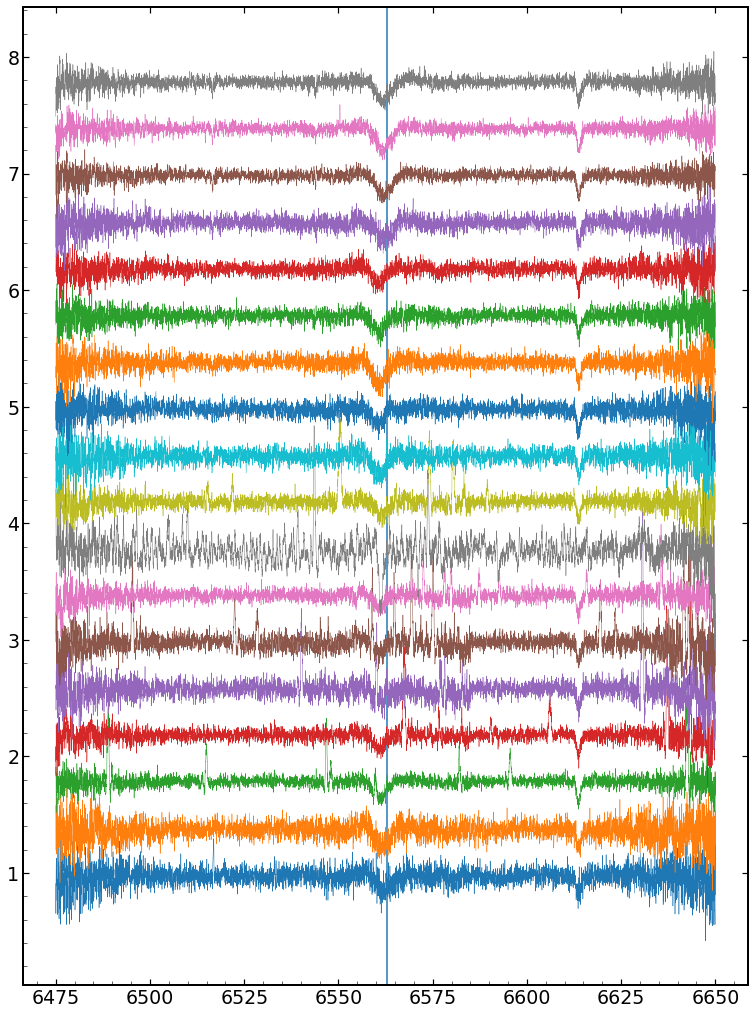

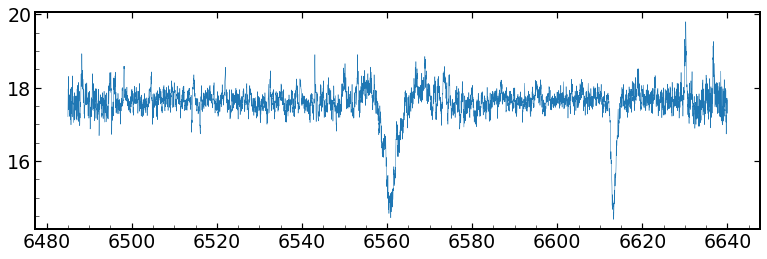

In [48]:
gmgsite = coord.EarthLocation.from_geodetic(lat=26.6951*units.deg, lon=100.03*units.deg, height=3200*units.m)
wave_dens = np.arange(6475, 6650, 0.02)
wave_dens0 = np.arange(6485, 6640, 0.02)
flux_dens = np.zeros(wave_dens0.shape)

n_speclist = len(filenames)
n_wvl = wave_dens0.shape[0]
fluxall = np.zeros((n_speclist, n_wvl))
fluxerrall = np.zeros((n_speclist, n_wvl))
obsjds = np.zeros(n_speclist)
obsbjds = np.zeros(n_speclist)

fig = plt.figure(figsize=(13,18))
ax = fig.add_subplot(1,1,1)
ax.axvline(x = 6563)
#all_sps = np.zeros((len(filenames), 3, len(wave_dens0)))
for _i, _fname in enumerate(filenames):
   specs = multispec(_fname)
   waves = specs['waves'][64:66]
   fluxs = specs['fluxs'][64:66]
   flux_errs = np.sqrt(fluxs) 
   wave_dens, fluxnorm_sum, fluxnorm_err = combine_spectrum_sum(waves, fluxs, flux_errs, wave_dens=wave_dens, speclist=None)
   T_sta = Time(specs['head']['DATE-STA'], format='isot', scale='utc') - 8.*units.hour
   T_end = Time(specs['head']['DATE-END'], format='isot', scale='utc')- 8.*units.hour
   jd = (T_sta.jd + T_end.jd)/2
   obsjds[_i] = jd
   jd_llt, ltt, _barycorr = eval_ltt(ra=62.794724868, dec=50.7082235439, jd=jd, site=gmgsite, kind='barycentric', barycorr=True)
   obsbjds[_i] = jd_llt
   flux_bc, fluxerr_bc = rvcorr_spec(wave_dens, fluxnorm_sum, fluxnorm_err, _barycorr.to('km/s').value, wave_new=wave_dens0, left=1, right=1)
   flux_dens += flux_bc
   plt.plot(wave_dens, fluxnorm_sum+_i*0.4, lw=0.5)
   fluxall[_i] = flux_bc
   fluxerrall[_i] = fluxerr_bc

fig = plt.figure(figsize=(13,4))
ax = fig.add_subplot(1,1,1)
plt.plot(wave_dens0, flux_dens, lw=0.5)

# Now, calculate radial velocity

- ceck sigle spectrum and its CCF

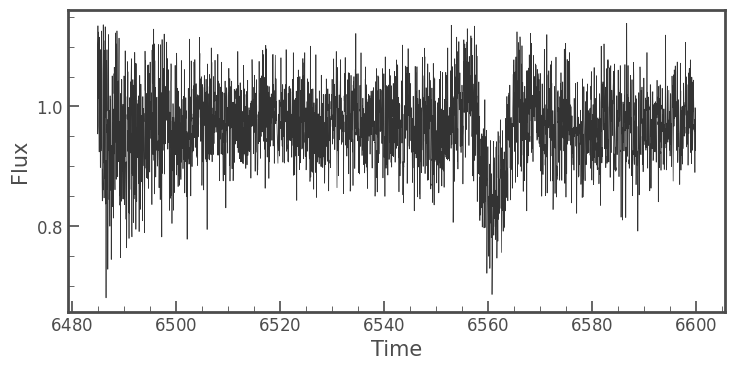

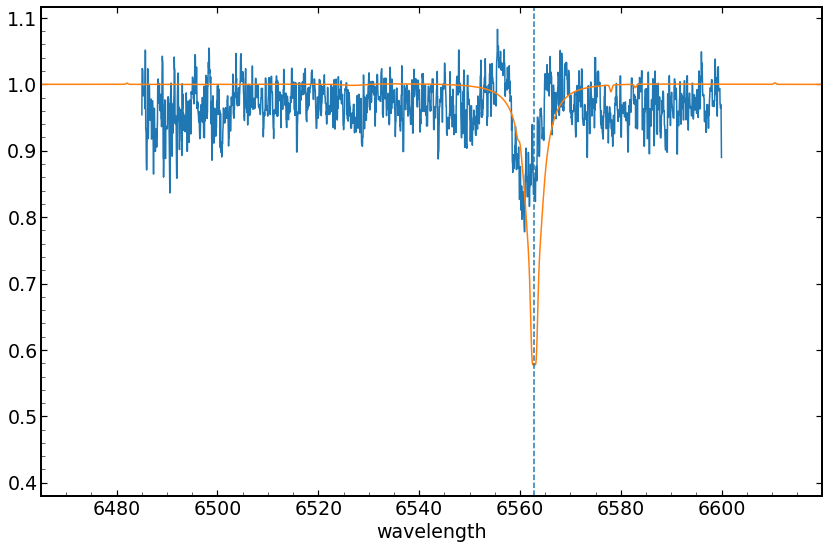

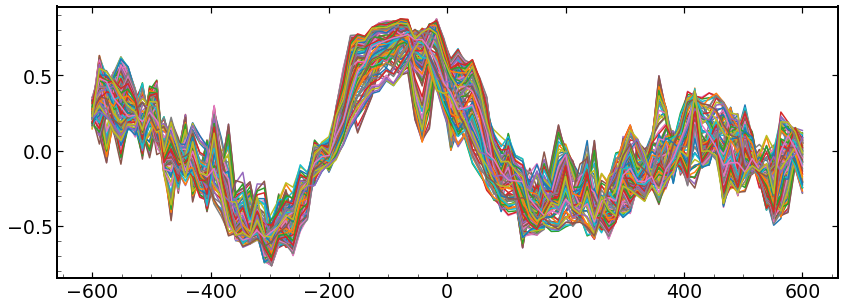

In [77]:
from laspec import ccf

_i = 1
wave = wave_dens0.copy()
flux = fluxall[_i].copy()
flux_err = fluxerrall[_i].copy()

ind = ~( (flux > 1.15) |
         (wave < 6480) |
         (wave > 6600)
       ) 


if True:
   spec = lk.LightCurve(time=wave[ind], flux=flux[ind], flux_err=flux_err[ind]) 
   ax = spec.plot()
wave_obs, flux_obs = wave[ind], flux[ind]
flux_obs = medfilt(flux_obs, kernel_size=11 )
rv_grid=np.linspace(-600, 600, 100)
ccf_grid = np.zeros((rvm.flux_mod.shape[0], rv_grid.shape[0]))
w_mod = rvm.weight_mod
for imod in range(rvm.nmod):
    ccf_grid[imod] = ccf.wxcorr_rvgrid(wave_obs, flux_obs, rvm.wave_mod, rvm.flux_mod[imod],
                                   w_mod=w_mod[imod], w_obs=None, rv_grid=rv_grid)[1]


fig = plt.figure(figsize=(14,9))
plt.plot(wave_obs, flux_obs)
#pltnorm = [plt.plot(waves[_], flux_norms[_]) for _ in np.arange(flux_norms.shape[0])]
pltmod =[plt.plot(rvm.wave_mod,  _ +0.01*__) for __, _ in enumerate(rvm.flux_mod[0:1])]
plt.xlabel('wavelength')
plt.xlim(wave_obs[0]-20, wave_obs[-1]+20)
plt.axvline(x=6562.79, ls='--')

fig = plt.figure(figsize=(14,5))
tt= plt.plot(rv_grid, ccf_grid.T)

In [54]:
print(wave.shape, flux.shape)

(7750,) (7750,)


In [81]:
rvsdic = {}
wave = wave_dens0.copy()

rvs = np.zeros((n_speclist, 2))
for _i, flux in enumerate(fluxall):
    ind = ~( (flux > 1.15) |
         (wave < 6480) |
         (wave > 6600)
       )  
    if False:
       spec = lk.LightCurve(time=wave[ind], flux=flux[ind], flux_err=flux_err[ind]) 
       spec.plot()
    wave_obs, flux_obs = wave[ind], flux[ind]
    flux_err_obs = flux_err[ind]
    #rvr = rvm.measure(wave_obs, flux_obs)
    rvr = rvm.measure(wave_obs, flux_obs, nmc=100, rv_grid=np.arange(-1000, 1000, 1),
                    )
    rvsdic[obsjds[_i]]= rvr
    rvs[_i][0] = rvr['rv_opt']

# coadd specra
- move the spectra to the rest frame of reference

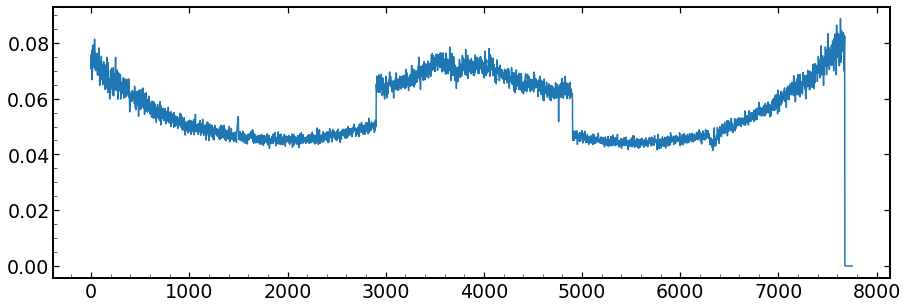

In [93]:
wave = wave_dens0.copy()
_fluxall = np.zeros_like(fluxall)
_fluxerrall = np.zeros_like(_fluxall)
for _i in np.arange(fluxall.shape[0]):
    #print(_i)
    flux = fluxall[_i]
    flux_err = fluxerrall[_i]
    rv = rvs[_i][0]
    flux_rv, fluxerr_rv = rvcorr_spec(wave, flux, flux_err, rv, left=0., right=0., interp1d=None)
    _fluxall[_i] = flux_rv
    _fluxerrall[_i] = fluxerr_rv
    

fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(1,1)
plt.plot(_fluxerrall[0])

# coadd specra

Page 127: 4.2.6. TheMLE Applied to a Heteroscedastic Gaussian Likelihood

- $\mu^0 = \frac{ \sum_l^N \omega_{l}x_{l}}{\sum_l^N \omega_{l}}$

- $\sigma_{\mu} = \left( \sum_l^N\frac{1}{\sigma_l^2} \right)^{-1/2} = \left( \sum_l^N\omega_l \right)^{-1/2}$

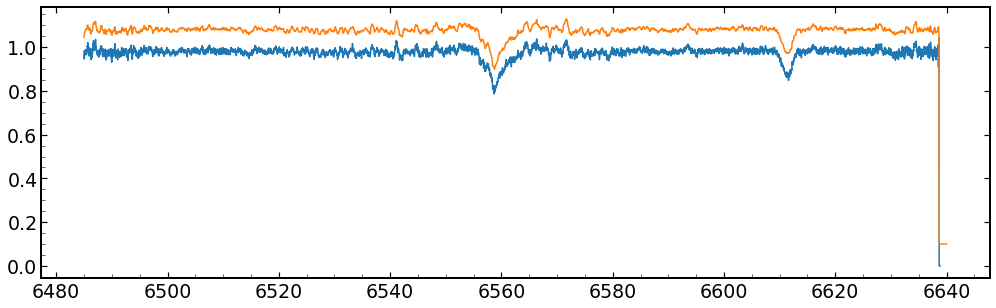

In [95]:
from scipy.signal import medfilt
wvl =  wave_dens0.copy()
_ind = _fluxall > 0.
_fluxallma = np.ma.array(fluxall, mask=~_ind)

_std = np.ma.std(_fluxallma, axis=0, ddof = 1)
_mean = np.ma.mean(_fluxallma, axis=0)
_indma = np.ma.abs(_fluxallma - _mean) < 4*_std

ivar = 1./_fluxerrall**2
ivar = np.ma.array(ivar, mask=~_indma.data)
sumivar = np.ma.sum(ivar, axis=0)
flux_coadd =  np.ma.sum(_fluxall * ivar/sumivar, axis=0)
flux_coadd_medfilt = medfilt(flux_coadd, kernel_size=11)
err_coadd = 1/np.sqrt(sumivar)

fig = plt.figure(figsize=(17, 5))
axs = fig.subplots(1,1)
plt.plot(wvl, flux_coadd)
plt.plot(wvl, flux_coadd_medfilt+0.1)

# save bfosc spectra

In [98]:
TYC3340_bfosc_spec = collections.OrderedDict(
                     obsjds = obsjds,
                     obsbjds = obsbjds,
                     fluxall = fluxall,
                     fluxerrall = fluxerrall, 
                     fluxall_crv = _fluxall,
                     fluxallerr_crv = _fluxerrall,
                     rvsdic = rvsdic,
                     rvs = rvs,
                     wavelength = wvl,
                     flux_coadd = flux_coadd,
                     err_coadd = err_coadd,
                     ivar = sumivar
                    )

joblib.dump(TYC3340_bfosc_spec, '/media/share/lijiao/TYC_3340-2437-1/TYC3340_HRS_spec.dump')

['/media/share/lijiao/TYC_3340-2437-1/TYC3340_HRS_spec.dump']

0 [-54.78061265   0.28829465]


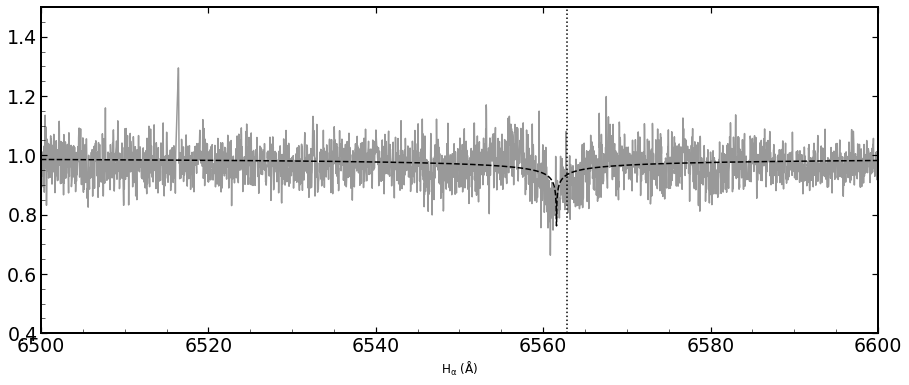

In [469]:
'''
###############################################
derive RV by fitting Halpha
###############################################
'''

import emcee, corner
from scipy.optimize import curve_fit

def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

def sersic(x,a,b,c,x0):
    return 1.-a*np.exp(-(np.abs(x-x0)/np.abs(b))**c)


def fit_sersic(ww,ff,p0=[0.8,4.,1.,4101.0]):
    popt,pcov = curve_fit(sersic,ww,ff,p0)
    ffm = sersic(ww,popt[0],popt[1],popt[2],popt[3])
    #plt.plot(ww,ff,'k')
    #plt.plot(ww,ffm,'b--')
    dy = (ffm-ff)
    ind = dy<np.percentile(dy,95)
    popt,pcov = curve_fit(sersic,ww[ind],ff[ind],p0)
    ffm = sersic(ww,popt[0],popt[1],popt[2],popt[3])
    #plt.plot(ww,ffm,'g--')
    dy = (ffm-ff)
    ind = dy<np.percentile(dy,95)
    popt,pcov = curve_fit(sersic,ww[ind],ff[ind],p0)
    ffm = sersic(ww,popt[0],popt[1],popt[2],popt[3])
    #plt.plot(ww,ffm,'r--')
    dy = (ffm-ff)
    ind = dy<np.percentile(dy,95)
    popt,pcov = curve_fit(sersic,ww[ind],ff[ind],p0, method='lm')
    ffm = sersic(ww,popt[0],popt[1],popt[2],popt[3])
    #plt.plot(ww,ffm,'m--')
    #plt.show()
    return popt,pcov
    
def lnprob_sersic(x,w,y):
    ym = sersic(w,x[0],np.abs(x[1]),x[2],x[3])
    dy = np.abs(ym-y)
    ind = dy<np.percentile(dy,99)
    return -np.sum(dy[ind]**2)

def sersic_mcmcfit(w,f,y0):
    # MCMC sampling
    n = len(f)
    
    #start to configure emcee
    nwalkers = 20
    ndim = 4
    p0=np.zeros((nwalkers,ndim))
    p0[:,0] = np.random.rand(nwalkers)*1
    p0[:,1] = np.random.rand(nwalkers)*10
    p0[:,2] = np.random.rand(nwalkers)*1
    p0[:,3] = np.random.rand(nwalkers)*1+y0
    #p0[:,4] = np.random.rand(nwalkers)*0.1+1.
      
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, lnprob_sersic, args=[w,f])
    
    pos, prob, state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    sampler.run_mcmc(pos, 10000)
    
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
    corner.corner(samples)
    popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov



n_spec = all_sps.shape[0]
sersic_resultsA = []
n_bfosc = 0
RVA = np.zeros((n_spec,2))
for _i in range(n_spec)[0:1]:
    w = all_sps[_i][0]
    f = all_sps[_i][1]
    indw = (w>6540) & (w<6600) & (f<1.1)
    try:
       popt,pcov = fit_sersic(w[indw],f[indw],p0=[0.8,3.,2.,6562.2])
    except Exception as error:
       print(error)
       popt,pcov = np.nan, np.nan 
       print('kkk')
    sersic_resultsA.append([popt,pcov])
    RVA[_i,:] = [(popt[-1]-6562.79)*299792.458/6562.79,np.sqrt(pcov[-1,-1])*299792.458/6562.79]
    print(_i,RVA[_i])
    
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)
for i in range(n_spec)[0:1]:
    popt = sersic_resultsA[i][0]
    if i<3:
        e1, = ax.plot(all_sps[i][0],all_sps[i][1]+0.2*i,'k-', alpha=0.4)
        
        ax.plot(all_sps[i][0],sersic(all_sps[i][0],popt[0],popt[1],popt[2],popt[3])+0.2*i,'k--')
    else:
        if i>5:
            if i==6:
                ax.plot(all_sps[i][0],all_sps[i][1]+0.2*i,'b-')
            else:
                ax.plot(all_sps[i][0],all_sps[i][1]+0.2*i,'g-')
            ax.plot(all_sps[i][0],sersic(all_sps[i][0],popt[0],popt[1],popt[2],popt[3])+0.2*i,'k--')
        else:
            e2, = ax.plot(all_sps[i][0],all_sps[i][2]+0.2*i,'r-')
            ax.plot(all_sps[i][0],sersic(all_sps[i][0],popt[0],popt[1],popt[2],popt[3])+0.2*i,'k--')
ax.axvline(x=6562.79,color='k', ls=':')
#plt.legend([e1,e2,e3],{'Keck/HiRES','LAMOST','P200/DBSP'},fontsize=12)
ax.set_xlim(6500,6600)
ax.set_ylim([0.4,1.5])
ax.set_xlabel(r'$H_\alpha$ ($\rm \AA$)',fontsize=12)

fig.show()

#fig.savefig("585014008Balmer_sersicfit_allspec.pdf",bbox_inches="tight")

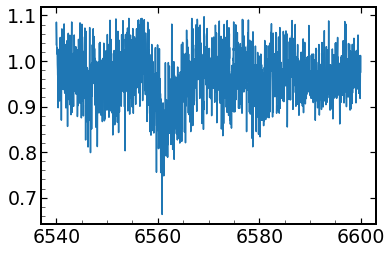

In [467]:
plt.plot(w[indw],f[indw])

In [470]:
3.e5/7500

40.0